In [1154]:
## NEW AND CLEAN NOTEBOOK, FINAL

In [1155]:
!pip install pandas matplotlib datetime yfinance numpy scipy scikit-learn pandas_market_calendars numpy pycopula



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1156]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math
from scipy.optimize import minimize

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula

## Data Import

In [1157]:
import pandas as pd
import numpy as np

# Load VIX data
file_path_vix = "../Data CSV/VIX.csv"
vix = pd.read_csv(file_path_vix)
vix.set_index("Date", inplace=True)
vix.index = pd.DatetimeIndex(vix.index)
vix = vix["Price"]
vix.sort_index(ascending=False, inplace=True)

# Load VSTOXX data
file_path_vstoxx = "../Data CSV/VSTOXX.csv"
vstoxx = pd.read_csv(file_path_vstoxx)
vstoxx.set_index("Date", inplace=True)
vstoxx.index = pd.DatetimeIndex(vstoxx.index)
vstoxx = vstoxx["Price"]
vstoxx.sort_index(ascending=False, inplace=True)

# Load VSMI data
file_path_vsmi = "../Data CSV/VSMI.csv"
vsmi = pd.read_csv(file_path_vsmi)
x = np.array([(i.split(";")[0], i.split(";")[2]) for i in list(vsmi["Date;ISIN;Indexvalue"])])
x[:, 1] = np.float16(x[:, 1])
x[:, 0] = [pd.to_datetime(i) for i in x[:, 0]]
vsmi = pd.DataFrame(data={"Price": np.float16(x[:, 1])}, index=[pd.to_datetime(i) for i in x[:, 0]])
vsmi.dropna(inplace=True)
vsmi.sort_index(ascending=False, inplace=True)
vsmi = vsmi["Price"]

# Construct vol_index dictionary
vol_index = {
    "SP500": vix,
    "STOXX50": vstoxx,
    "SMI": vsmi
}

# Filter for dates after 2022-01-01 and forward fill
for key in vol_index:
    vol_index[key] = vol_index[key][vol_index[key].index >= pd.to_datetime('2021-01-06')].sort_index()
    vol_index[key] = vol_index[key].astype("float32").asfreq('D').fillna(method='ffill')

# Convert vol_index to a dataframe
vol_index_df = pd.DataFrame({
    key: vol_index[key] for key in vol_index
})
vol_index = vol_index_df.ffill()
vol_index = vol_index/100

/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26097/2426478072.py:25: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  x[:, 0] = [pd.to_datetime(i) for i in x[:, 0]]
/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26097/2426478072.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol_index[key] = vol_index[key].astype("float32").asfreq('D').fillna(method='ffill')
/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26097/2426478072.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol_index[key] = vol_index[key].astype("float32").asfreq('D').fillna(method='ffill')
/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26097/2426478072.py:41: FutureWarning: Ser

In [1158]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2024-01-01')

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    data = data[data.index > "2020-01-01"]
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

## Divide to convert chf to usd, multiply for other way

dates = pd.bdate_range(start=start_date,end=final_date)

interest_rates = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
interest_rates.columns = interest_rates.columns.str.strip()
interest_rates = interest_rates.dropna(subset=["United States Treasury 10-YR Rates"])
interest_rates["United States Treasury 10-YR Rates"] = pd.to_numeric(
    interest_rates["United States Treasury 10-YR Rates"], errors="coerce"
)
interest_rates.index = pd.DatetimeIndex(interest_rates["Dates"])
full_date_range = pd.date_range(start=interest_rates.index.min(), end=interest_rates.index.max())
interest_rates = interest_rates.reindex(full_date_range).ffill()
interest_rates.index.name = "Dates"
interest_rates.head()

r = interest_rates["United States Treasury 10-YR Rates"].dropna()
r = np.log(1+0.01*r)

sp500_init_level = 3977
stoxx_init_level_local = 4164
smi_init_level_local = 10786
##Double checked
dt = 1/252


Data Loss: 0.970348204570185


In [1159]:
def calculate_pv_interest(start_date, risk_free_rate):

    payment_dates = pd.DatetimeIndex(['2023-07-03', '2023-10-03', '2024-01-03', '2024-04-03',
               '2024-07-03', '2024-10-03'],
              dtype='datetime64[ns]', freq=None)

    pv_interest = sum([
        1000 * 0.025 * math.exp(-risk_free_rate * ((payment_date - start_date).days / 365.0))
        for payment_date in payment_dates if payment_date > start_date
    ])

    return pv_interest

In [1160]:
def price_barrier_reverse_convertible(start_date, price_paths ):
    final_date = pd.to_datetime('2024-09-26')
    start_date = pd.to_datetime(start_date)
    T = (final_date - start_date).days / 365.0

    # Converting all the prices to USD
    eur_usd = eur["Price"][start_date]
    chf_usd = chf["Price"][start_date]
    stoxx_init_level = stoxx_init_level_local / eur_usd
    smi_init_level = smi_init_level_local / chf_usd
    sp500_barrier = sp500_init_level * 0.65
    stoxx_barrier = stoxx_init_level * 0.65
    smi_barrier = smi_init_level * 0.65

    payment_dates = [start_date + pd.DateOffset(months=3*i) for i in range(1, 5)]
    payment_dates = [d for d in payment_dates if d <= final_date]

    risk_free_rate = r[r.index <= start_date].iloc[-1]

    pv_interest = calculate_pv_interest(start_date, risk_free_rate)

    discount_factor_maturity = math.exp(-risk_free_rate * T)

    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    sim_length = len(sim_dates)

    num_sims = len(price_paths['SMI'])

    prices = np.zeros(num_sims)
    for i in range(num_sims):
        sim_SMI = np.array(price_paths['SMI'][i][:sim_length])
        sim_SP500 = np.array(price_paths['SP500'][i][:sim_length])
        sim_STOXX50 = np.array(price_paths['STOXX50'][i][:sim_length])

        barrier_breached = (
            (sim_SMI < smi_barrier).any() or
            (sim_SP500 < sp500_barrier).any() or
            (sim_STOXX50 < stoxx_barrier).any()
        )

        if not barrier_breached:
            pv_redemption = 1000 * discount_factor_maturity
        else:

            final_SMI = sim_SMI[-1]
            final_SP500 = sim_SP500[-1]
            final_STOXX50 = sim_STOXX50[-1]

            perf_SMI = final_SMI / smi_init_level
            perf_SP500 = final_SP500 / sp500_init_level
            perf_STOXX50 = final_STOXX50 / stoxx_init_level
            worst_perf = min(perf_SMI, perf_SP500, perf_STOXX50, 1)
            pv_redemption = 1000 * discount_factor_maturity * worst_perf
        price = pv_interest + pv_redemption
        prices[i] = price
    return prices

## Different models

In [ ]:
sigma = {}
for index in ['SMI', 'STOXX50', 'SP500']:
    variance = returns[index].var(ddof= 1)*252
    sigma[index] = np.sqrt(variance)
    #NOTE: REMEMBER TO CHANGE THIS
    historical_vol = (returns.rolling(90).std()).asfreq('D').ffill()*np.sqrt(252)


corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

price_data = {
        'SMI': smi,
        'STOXX50': stoxx50,
        'SP500': sp500
    }
indices = ['SMI', 'STOXX50', 'SP500']

In [1162]:
def simulate_gbm(start_date, n_simulations = 100000, verbose = False, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    dt = 1 / 252

    risk_free_rate = r[r.index <= start_date].iloc[-1]
    n_timesteps = len(dates)

    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_flat = Z.reshape(-1, 3)
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
    initial_prices = {}
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)


    price_paths = {
        'SMI': np.zeros((n_timesteps + 1, n_simulations)),
        'STOXX50': np.zeros((n_timesteps + 1, n_simulations)),
        'SP500': np.zeros((n_timesteps + 1, n_simulations))
    }

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]

    for i in range(1, n_timesteps + 1):
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (risk_free_rate - 0.5 * sigma[index] ** 2)*dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index]= price_paths[index].transpose()
    T = (final_date-start_date).days/352
    if not verbose:
        return price_paths

    print()
    for i in mu:
        print(i, "mu:", mu.get(i), "std:", sigma.get(i))
        print(i, "expected mu:", mu.get(i)*T, "std:", sigma.get(i)*np.sqrt(T))
        print()
    for i in price_paths:
        print(i)
        paths = price_paths.get(i)
        print("| Mean Price:", np.mean([i[-1] for i in paths]), "| Mean Return:", np.mean([i[-1] for i in paths])/paths[0][0], "| SD of Return:", np.std(np.array([i[-1] for i in paths])/paths[0][0]))
    return price_paths

In [1163]:
# Define the negative log-likelihood function. Here we fix theta to be 3.84%, according to US Long-Term Monthly Rate Analysis
def negative_log_likelihood_fixed_theta(params, r_df, theta=0.0384):
    kappa, sigma_r = params
    if kappa <= 0 or sigma_r <= 0:
        return np.inf
    log_likelihood = 0
    rates = r_df.values
    dates = r_df.index
    for t in range(len(rates) - 1):
        r_t = rates[t]
        r_t1 = rates[t + 1]
        dr = r_t1 - r_t
        dt_days = (dates[t + 1] - dates[t]).days
        dt = dt_days / 252
        if dt <= 0:
            continue
        mean_increment = kappa * (theta - r_t) * dt
        variance_increment = sigma_r**2 * r_t * dt
        if variance_increment <= 0:
            return np.inf
        likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
            (dr - mean_increment) ** 2 / variance_increment
        )
        log_likelihood += likelihood_t
    return -log_likelihood

# Initial guesses and bounds for kappa and sigma_r
initial_vals = [0.1, np.std(r.values)]
bounds = ((1e-5, None), (1e-5, None))

# Optimization with fixed theta
result = scipy.optimize.minimize(
    negative_log_likelihood_fixed_theta, initial_vals, args=(r,dt), bounds=bounds, method="L-BFGS-B"
)

kappa, sigma_r = result.x
theta = np.log(1+0.0384)
print("Fitted Parameters with Theta Fixed at 0.0384:")
print("kappa:", kappa)
print("sigma_r:", sigma_r)
print("theta:", theta)



Fitted Parameters with Theta Fixed at 0.0384:
kappa: 1e-05
sigma_r: 0.05580666435095845
theta: 0.037681066967688484


In [1164]:
def simulate_price_paths_with_CIR(start_date, n_simulations, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')

    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)

    corr_matrix = returns[indices].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    Z = np.random.normal(size=(n_timesteps, n_simulations, len(indices)))
    Z_flat = Z.reshape(-1, len(indices))
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, len(indices))
    initial_prices = {}

    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]

    initial_rate = r[start_date]

    r_paths = np.zeros((n_timesteps + 1, n_simulations))
    # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
    r_paths[0, :] = initial_rate


    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[i - 1]
        dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
        r_paths[i] = np.maximum(r_t_prev + dr, 0)


        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
            # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index] = price_paths[index].transpose()
    return price_paths, r_paths


In [1165]:
# start_date = '2024-01-01'
# final_date= '2024-09-16'
# n_simulations = 100
# n_timesteps = len(pd.bdate_range(start=start_date,end=final_date))

# Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
# Z_flat = Z.reshape(-1, 3)
# Z_correlated_flat = Z_flat @ chol_matrix.T
# Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

# smi = smi[pd.to_datetime(smi['Date'])>= pd.to_datetime(start_date)]
# sp500 = sp500[pd.to_datetime(sp500['Date'])>= pd.to_datetime(start_date)]
# stoxx50 = stoxx50[pd.to_datetime(stoxx50['Date'])>= pd.to_datetime(start_date)]

# initial_prices = {
#     'SMI': smi['Price'].iloc[-1],
#     'STOXX50': stoxx50['Price'].iloc[-1],
#     'SP500': sp500['Price'].iloc[-1]
# }


# price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
# for index in ['SMI', 'STOXX50', 'SP500']:
#     price_paths[index][0] = initial_prices[index]

# initial_rate = r[start_date]

# print("Initial Interest Rate:", initial_rate)


# r_paths = np.zeros((n_timesteps + 1, n_simulations))
# # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
# r_paths[0, :] = initial_rate


# for i in range(1, n_timesteps + 1):
#     Z_r = np.random.normal(size=n_simulations)
#     r_t_prev = r_paths[i - 1]
#     dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
#     r_paths[i] = np.maximum(r_t_prev + dr, 0)


#     for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
#         drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
#         # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
#         diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
#         price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

# for index in ['SMI', 'STOXX50', 'SP500']:
#     price_paths[index] = price_paths[index].transpose()


In [1166]:
def empirical_martingale_correction(price_data, r):
    r = np.log(1+0.01*r)
    price_data_new = {}

    for i in price_data:
        s = price_data.get(i)
        Z = np.zeros_like(s)
        s_ = np.zeros_like(s)
        s_[:,0] = s[:,0]
        r = np.log(1.03)
        for j in range(1, s.shape[1]):
            t_j = j * dt
            Z[:, j] = (s_[:, j-1] / s[:, j-1]) * s[:, j]
            Z_sum = np.average(Z[:, j], axis=0)
            Z0_j = np.exp(-r * t_j) * Z_sum
            s_[:, j] = s[:, 0] * Z[:, j] / Z0_j
        price_data_new[i] = s_
    return price_data_new


In [1167]:
dt = 1 / 252

def calibrate_heston_params(vol_data):
    def objective(params):
        kappa_v, theta_v, sigma_v, rho_v = params
        mean_vol = np.mean(vol_data)
        var_vol = np.var(vol_data)

        model_mean_vol = theta_v
        model_var_vol = sigma_v ** 2 / (2 * kappa_v)

        return (mean_vol - model_mean_vol) ** 2 + (var_vol - model_var_vol) ** 2
    initial_params = [0.5, 0.1549253194855805, 0.1, -0.7]
    bounds = [(0, None), (0, None), (0, None), (-1, 1)]
    result = minimize(objective, initial_params, bounds=bounds)
    kappa_v, theta_v, sigma_v, rho_v = result.x
    return kappa_v, theta_v, sigma_v, rho_v

# Calibrate Heston parameters for each index
calibrated_params = {}
for index, vol_data in vol_index.items():
    calibrated_params[index] = calibrate_heston_params(vol_data/100)

def simulate_price_paths_with_heston_CIR(start_date, n_simulations, calibrated_params, vol_index, h_percentage_change={'SMI': 1.0, 'STOXX50': 1.0, 'SP500': 1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')
    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)

    corr_matrix = returns[indices].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    Z = np.random.normal(size=(n_timesteps, n_simulations, len(indices)))
    Z_flat = Z.reshape(-1, len(indices))
    Z_r_flat = Z_flat @ chol_matrix.T
    Z_r = Z_r_flat.reshape(n_timesteps, n_simulations, len(indices))

    initial_prices = {}
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)    

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in initial_prices.keys()}
    vol_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in initial_prices.keys()}

    for index in price_paths.keys():
        price_paths[index][0] = initial_prices[index]
        vol_paths[index][0] = vol_index[index]

    initial_rate = r[start_date]

    r_paths = np.zeros((n_timesteps + 1, n_simulations))
    r_paths[0, :] = initial_rate

    for i in range(1, n_timesteps + 1):
        Z_rates = np.random.normal(size=n_simulations)
        r_prev = r_paths[i - 1]
        dr = kappa * (theta - r_prev) * dt + sigma_r * np.sqrt(r_prev * dt) * Z_rates
        r_paths[i] = np.maximum(r_prev + dr, 0)

        for index in price_paths.keys():
            kappa_v, theta_v, sigma_v, rho_v = calibrated_params[index]

            corr_matrix = np.array([[1, rho_v], [rho_v, 1]])
            chol_matrix = np.linalg.cholesky(corr_matrix)
            Z = np.random.normal(size=(n_timesteps, n_simulations, 2))
            Z_flat = Z.reshape(-1, 2)
            Z_correlated_flat = Z_flat @ chol_matrix.T
            Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 2)

            v_prev = vol_paths[index][i - 1]
            dv = kappa_v * (theta_v - v_prev) * dt + sigma_v * np.sqrt(v_prev * dt) * Z_correlated[i - 1, :, 0]
            vol_paths[index][i] = np.maximum(v_prev + dv, 0)

            drift_term = (r_paths[i] - 0.5 * (vol_paths[index][i]**2)) * dt
            diffusion_term = vol_paths[index][i] * np.sqrt(dt) * Z_r[i - 1, :,1]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

    for index in price_paths.keys():
        price_paths[index] = price_paths[index].transpose()
        vol_paths[index] = vol_paths[index].transpose()
    return price_paths, vol_paths, r_paths



In [1168]:
def simulate_price_paths_with_CIR(start_date, n_simulations, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')

    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)

    corr_matrix = returns[indices].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    Z = np.random.normal(size=(n_timesteps, n_simulations, len(indices)))
    Z_flat = Z.reshape(-1, len(indices))
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, len(indices))
    initial_prices = {}

    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]

    initial_rate = r[start_date]

    r_paths = np.zeros((n_timesteps + 1, n_simulations))
    # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
    r_paths[0, :] = initial_rate


    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[i - 1]
        dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
        r_paths[i] = np.maximum(r_t_prev + dr, 0)


        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
            # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index] = price_paths[index].transpose()
    return price_paths, r_paths


In [1169]:
calibrated_params

{'SP500': (np.float64(0.5075082176855922),
  np.float64(0.0019352200751558875),
  np.float64(0.007452556100319966),
  np.float64(-0.7)),
 'STOXX50': (np.float64(0.5075019273338615),
  np.float64(0.0020212928237143464),
  np.float64(0.007389811421393607),
  np.float64(-0.7)),
 'SMI': (np.float64(0.5076097578526593),
  np.float64(0.0016479343789463318),
  np.float64(0.007209187694832579),
  np.float64(-0.7))}

In [1170]:
np.average(vol_index["SMI"])

np.float32(0.16481557)

## Pricing

In [1171]:
# final_date = pd.to_datetime('2024-09-26')
# start_date = pd.to_datetime('2023-09-01')
# dates = pd.bdate_range(start = start_date, end = '2024-01-01')
# price_chart = pd.DataFrame({"Start_Date":[], "GBM_Mean_Price":[], "GBM_Mean_Price_EMcorrection":[], "CIR_Mean_Price":[]})
# for start_date in dates:
#     nsim = 1000
#     sigma = {}
#     for index in ['SMI', 'STOXX50', 'SP500']:
#         #variance = returns[index].var(ddof= 1)*252
#         t = vol_index.get(index)
#         vol = t[t.index > start_date].iloc[-1].item()
#         sigma[index] = vol/100

#     price_paths = simulate_gbm(start_date, n_simulations= nsim)
#     gbm = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)

#     price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
#     GBM_EMcorrection = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)

#     price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim)
#     cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)

#     price_chart.loc[len(price_chart)+1] = {"Start_Date": start_date, "GBM_Mean_Price": np.mean(gbm), "GBM_Mean_Price_EMcorrection": np.mean(GBM_EMcorrection), "CIR_Mean_Price": np.mean(cir)}
#     print(start_date)
# price_chart.set_index("Start_Date", inplace = True)


In [1182]:
vol_index

SP500  STOXX50       SMI
2021-01-06  0.2507   0.2144  0.177656
2021-01-07  0.2237   0.2102  0.144063
2021-01-08  0.2156   0.2053  0.144063
2021-01-09  0.2156   0.2053  0.155078
2021-01-10  0.2156   0.2053  0.164844
...            ...      ...       ...
2024-12-07  0.1518   0.1794  0.118125
2024-12-08  0.1518   0.1794  0.130156
2024-12-09  0.1518   0.1794  0.148750
2024-12-10  0.1518   0.1794  0.148750
2024-12-11  0.1518   0.1794  0.144922

[1436 rows x 3 columns]

In [1172]:
historical_prices = pd.read_csv("../Data CSV/prices_data.csv", parse_dates=["date"])
historical_prices.set_index("date", inplace=True)


price_chart = pd.DataFrame({
    "Start_Date": [],
    "Historical_Price": [],
    # "GBM_Mean_Price_Sigma": [],
    # "GBM_Mean_Price_EMcorrection_Sigma": [],
    # "CIR_Mean_Price_Sigma": [],
    # "GBM_Mean_Price_VolIndex": [],
    # "GBM_Mean_Price_EMcorrection_VolIndex": [],
    # "CIR_Mean_Price_VolIndex": [],
    "Heston_Mean_Price_VolIndex": []
})

# Define time range and parameters
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2023-09-01')
dates = pd.bdate_range(start=start_date, end='2024-01-01')

nsim = 10000

# First loop for Sigma-based volatility
for start_date in dates:

    sigma = {}
    # Calculate sigma based on the historical variance method
    sigma = vol_index.loc[start_date].to_dict()

    # Run the simulation with calculated sigma
    # price_paths = simulate_gbm(start_date, n_simulations=nsim)
    # gbm_sigma = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    # price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    # GBM_EMcorrection_sigma = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    # price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations=nsim)
    # price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    # cir_sigma = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)
    # Retrieve the historical price for the current start_date
    historical_price = historical_prices.loc[start_date, "value"] if start_date in historical_prices.index else None

    # Append results for Sigma-based volatility
    price_chart.loc[len(price_chart) + 1] = {
        "Start_Date": start_date,
        "Historical_Price": historical_price,

        # "GBM_Mean_Price_Sigma": np.mean(gbm_sigma),
        # "GBM_Mean_Price_EMcorrection_Sigma": np.mean(GBM_EMcorrection_sigma),
        # "CIR_Mean_Price_Sigma": np.mean(cir_sigma),
        # "GBM_Mean_Price_VolIndex": None,
        # "GBM_Mean_Price_EMcorrection_VolIndex": None,
        # "CIR_Mean_Price_VolIndex": None,
        "Heston_Mean_Price_VolIndex": None

    }

# Second loop for Volatility Index-based volatility
for start_date in dates:
    sigma = vol_index.loc[start_date].to_dict()
    print(start_date)
    # historical_vol = (returns.rolling(90).std()).asfreq('D').ffill()*np.sqrt(252)


    # price_paths = simulate_gbm(start_date, n_simulations=nsim)
    # gbm_vol_index = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    # price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    # GBM_EMcorrection_vol_index = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    # price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations=nsim)
    # price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    # cir_vol_index = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    price_paths, vol_paths, r_paths = simulate_price_paths_with_heston_CIR(
    start_date, n_simulations=nsim, calibrated_params=calibrated_params, vol_index=sigma)

    # Calculate Heston results for Volatility Index-based volatility
    heston_vol_index = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)


    # Update existing rows with Volatility Index-based volatility results
    price_chart.loc[price_chart["Start_Date"] == start_date, [
        # "GBM_Mean_Price_VolIndex",
        # "GBM_Mean_Price_EMcorrection_VolIndex",
        # "CIR_Mean_Price_VolIndex",
        "Heston_Mean_Price_VolIndex"
    ]] = [
        # np.mean(gbm_vol_index),
        # np.mean(GBM_EMcorrection_vol_index),
        # np.mean(cir_vol_index),
        np.mean(heston_vol_index)
    ]
    print(price_chart)


# Set the Start_Date as index
price_chart.set_index("Start_Date", inplace=True)




2023-09-01 00:00:00


/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26097/831776462.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  price_chart.loc[len(price_chart) + 1] = {
/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26097/831776462.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  price_chart.loc[len(price_chart) + 1] = {
/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_26097/831776462.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA en

   Start_Date  Historical_Price Heston_Mean_Price_VolIndex
1  2023-09-01            100.83                1075.535242
2  2023-09-04             99.20                       None
3  2023-09-05             99.26                       None
4  2023-09-06             98.99                       None
5  2023-09-07             98.93                       None
..        ...               ...                        ...
83 2023-12-26               NaN                       None
84 2023-12-27            101.46                       None
85 2023-12-28            101.33                       None
86 2023-12-29            101.39                       None
87 2024-01-01               NaN                       None

[87 rows x 3 columns]
2023-09-04 00:00:00
   Start_Date  Historical_Price Heston_Mean_Price_VolIndex
1  2023-09-01            100.83                1075.535242
2  2023-09-04             99.20                1076.561311
3  2023-09-05             99.26                       None
4  2023-09-06

In [1174]:
print(price_barrier_reverse_convertible(start_date=pd.to_datetime('2023-09-01'), price_paths=price_paths))


[1079.11501989 1079.11501989 1079.11501989 ... 1079.11501989 1079.11501989
 1079.11501989]


In [1175]:
price_chart["Historical_Price"] = price_chart["Historical_Price"] *10

In [1176]:
price_chart.describe

<bound method NDFrame.describe of             Historical_Price Heston_Mean_Price_VolIndex
Start_Date                                             
2023-09-01            1008.3                1075.535242
2023-09-04             992.0                1076.561311
2023-09-05             992.6                1076.744703
2023-09-06             989.9                   1075.924
2023-09-07             989.3                  1077.1889
...                      ...                        ...
2023-12-26               NaN                1068.762451
2023-12-27            1014.6                1069.555361
2023-12-28            1013.3                1068.849209
2023-12-29            1013.9                1068.397946
2024-01-01               NaN                 1068.82235

[87 rows x 2 columns]>

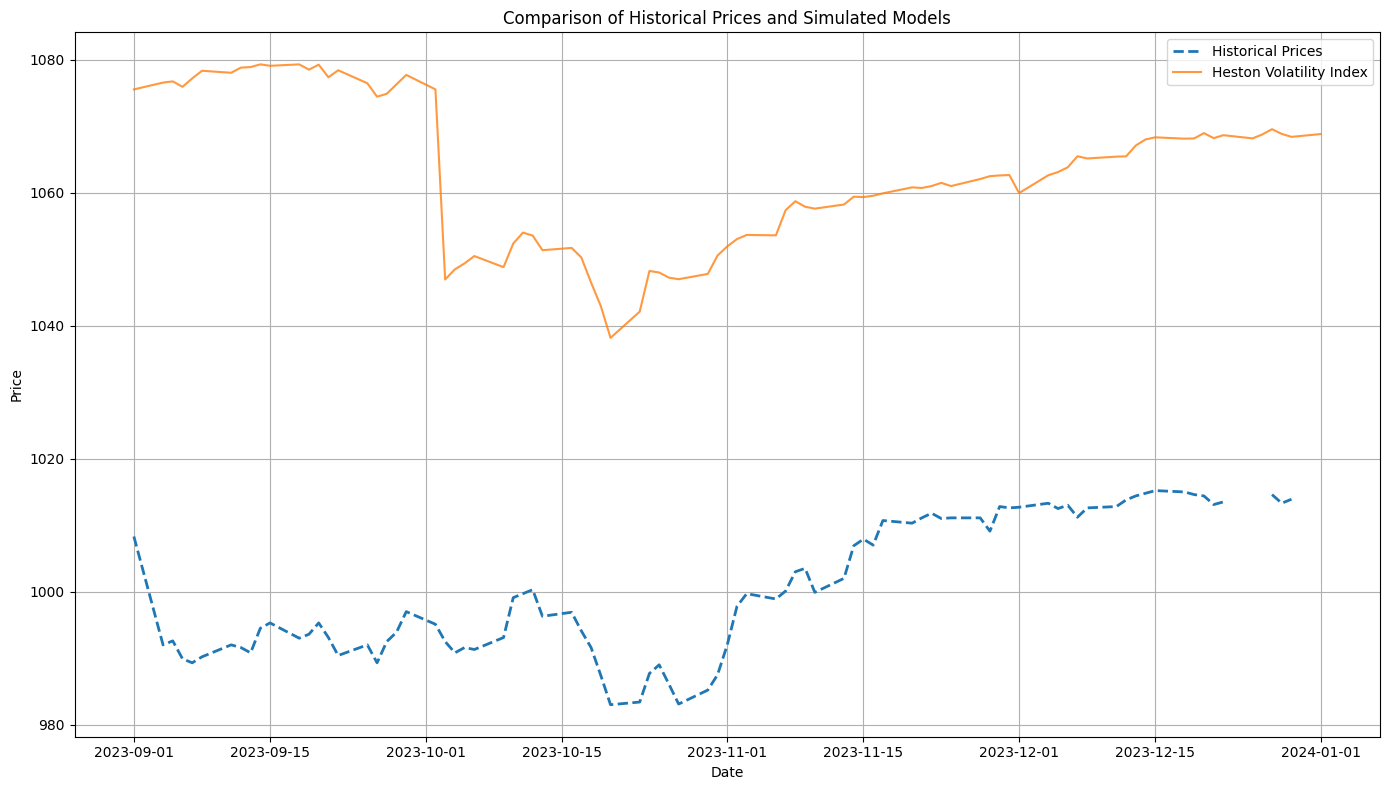

In [1177]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot historical prices against different models
plt.figure(figsize=(14, 8))

# Plot historical prices
plt.plot(price_chart.index, price_chart["Historical_Price"], label="Historical Prices", linestyle='--', linewidth=2)

# Plot models
plt.plot(price_chart.index, price_chart["Heston_Mean_Price_VolIndex"], label="Heston Volatility Index", alpha=0.8)

# Add labels, legend, and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of Historical Prices and Simulated Models")
plt.legend(loc="best")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [1334]:
model_results = pd.read_csv("overlunch_price_chart.csv")

In [1335]:
price_chart["Heston_Mean_Price_VolIndex"]

Start_Date
2023-09-01    1075.535242
2023-09-04    1076.561311
2023-09-05    1076.744703
2023-09-06       1075.924
2023-09-07      1077.1889
                 ...     
2023-12-26    1068.762451
2023-12-27    1069.555361
2023-12-28    1068.849209
2023-12-29    1068.397946
2024-01-01     1068.82235
Name: Heston_Mean_Price_VolIndex, Length: 87, dtype: object

In [1336]:
print(price_chart.columns)
print(model_results.columns)

Index(['Historical_Price', 'Heston_Mean_Price_VolIndex'], dtype='object')
Index(['Start_Date', 'Historical_Price', 'GBM_Mean_Price_Sigma',
       'GBM_Mean_Price_EMcorrection_Sigma', 'CIR_Mean_Price_Sigma',
       'GBM_Mean_Price_VolIndex', 'GBM_Mean_Price_EMcorrection_VolIndex',
       'CIR_Mean_Price_VolIndex', 'Heston_Mean_Price_Sigma',
       'Heston_Mean_Price_VolIndex'],
      dtype='object')


In [1337]:
model_results=model_results.drop(columns="Heston_Mean_Price_Sigma")

In [1338]:
model_results   

Start_Date  Historical_Price  GBM_Mean_Price_Sigma  \
0   2023-09-01            1008.3           1078.572043   
1   2023-09-04             992.0           1078.704289   
2   2023-09-05             992.6           1078.026078   
3   2023-09-06             989.9           1077.781533   
4   2023-09-07             989.3           1078.126890   
..         ...               ...                   ...   
82  2023-12-26               NaN           1069.774719   
83  2023-12-27            1014.6           1070.389224   
84  2023-12-28            1013.3           1070.230109   
85  2023-12-29            1013.9           1070.047387   
86  2024-01-01               NaN           1070.163239   

    GBM_Mean_Price_EMcorrection_Sigma  CIR_Mean_Price_Sigma  \
0                         1078.477426           1046.937507   
1                         1078.622023           1045.627496   
2                         1077.982470           1046.385757   
3                         1077.743556           1045.129065   
4                         1078.057912           1045.659323   
..                                ...                   ...   
82                        1069.732171           1056.728973   
83                        1070.333867           1056.078071   
84                        1070.180830           1055.916648   
85                        1069.993742           1056.655025   
86                        1070.119929           1055.569748   

    GBM_Mean_Price_VolIndex  GBM_Mean_Price_EMcorrection_VolIndex  \
0               1078.960685                           1078.959876   
1               1079.206153                           1079.179229   
2               1078.525260                           1078.504596   
3               1078.435367                           1078.428527   
4               1078.889360                           1078.882438   
..                      ...                                   ...   
82              1070.063256                           1070.035733   
83              1070.756658                           1070.735481   
84              1070.426291                           1070.397532   
85              1070.384984                           1070.377056   
86              1070.747036                           1070.739443   

    CIR_Mean_Price_VolIndex  Heston_Mean_Price_VolIndex  
0               1061.028300                  123.342768  
1               1061.108098                  123.353095  
2               1061.143665                  123.344661  
3               1065.716963                  123.372207  
4               1068.937111                  123.517927  
..                      ...                         ...  
82              1064.817041                  104.831852  
83              1063.292852                  105.025494  
84              1061.550382                  105.117089  
85              1064.540259                  105.142944  
86              1065.261928                  105.557149  

[87 rows x 9 columns]

In [1339]:
# Ensure that the correct column name is used
model_results.set_index('Start_Date', inplace=True)

# Add the column from price_chart to model_results
model_results['Heston_Mean_Price_VolIndex'] = price_chart['Heston_Mean_Price_VolIndex']

# Reset the index if necessary
model_results.reset_index(inplace=True)

In [1340]:
model_results

Start_Date  Historical_Price  GBM_Mean_Price_Sigma  \
0   2023-09-01            1008.3           1078.572043   
1   2023-09-04             992.0           1078.704289   
2   2023-09-05             992.6           1078.026078   
3   2023-09-06             989.9           1077.781533   
4   2023-09-07             989.3           1078.126890   
..         ...               ...                   ...   
82  2023-12-26               NaN           1069.774719   
83  2023-12-27            1014.6           1070.389224   
84  2023-12-28            1013.3           1070.230109   
85  2023-12-29            1013.9           1070.047387   
86  2024-01-01               NaN           1070.163239   

    GBM_Mean_Price_EMcorrection_Sigma  CIR_Mean_Price_Sigma  \
0                         1078.477426           1046.937507   
1                         1078.622023           1045.627496   
2                         1077.982470           1046.385757   
3                         1077.743556           1045.129065   
4                         1078.057912           1045.659323   
..                                ...                   ...   
82                        1069.732171           1056.728973   
83                        1070.333867           1056.078071   
84                        1070.180830           1055.916648   
85                        1069.993742           1056.655025   
86                        1070.119929           1055.569748   

    GBM_Mean_Price_VolIndex  GBM_Mean_Price_EMcorrection_VolIndex  \
0               1078.960685                           1078.959876   
1               1079.206153                           1079.179229   
2               1078.525260                           1078.504596   
3               1078.435367                           1078.428527   
4               1078.889360                           1078.882438   
..                      ...                                   ...   
82              1070.063256                           1070.035733   
83              1070.756658                           1070.735481   
84              1070.426291                           1070.397532   
85              1070.384984                           1070.377056   
86              1070.747036                           1070.739443   

    CIR_Mean_Price_VolIndex Heston_Mean_Price_VolIndex  
0               1061.028300                1075.535242  
1               1061.108098                1076.561311  
2               1061.143665                1076.744703  
3               1065.716963                   1075.924  
4               1068.937111                  1077.1889  
..                      ...                        ...  
82              1064.817041                1068.762451  
83              1063.292852                1069.555361  
84              1061.550382                1068.849209  
85              1064.540259                1068.397946  
86              1065.261928                 1068.82235  

[87 rows x 9 columns]

In [1341]:
model_results["Heston_Mean_Price_VolIndex"] = model_results["Heston_Mean_Price_VolIndex"] -10

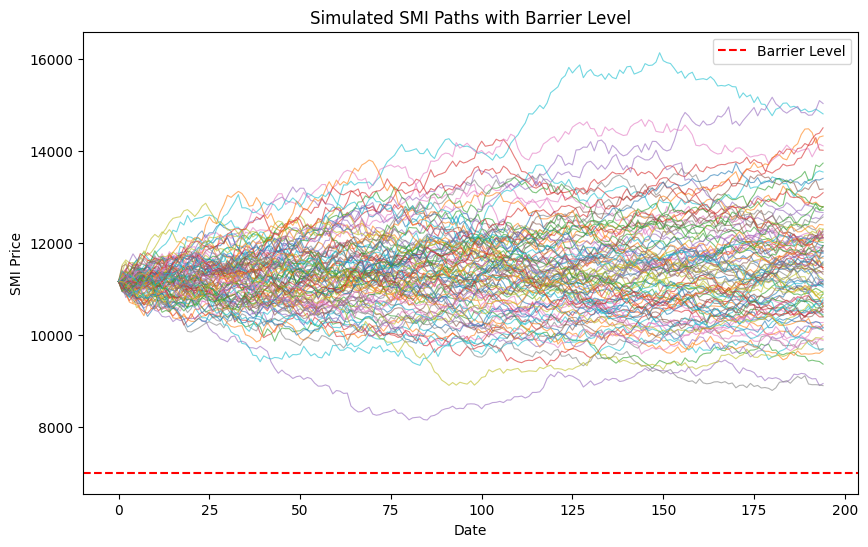

In [1342]:
plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot( price_paths['SMI'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=7011, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("SMI Price")
plt.title("Simulated SMI Paths with Barrier Level")
plt.legend()
plt.show()

In [1343]:
asdf = pd.read_csv("overnight_price_chart.csv")
asdf.set_index("Start_Date")

av_data
Start_Date             
2023-09-01  1078.807037
2023-09-04  1079.372159
2023-09-05  1078.594127
2023-09-06  1078.405221
2023-09-07  1078.909922
...                 ...
2023-12-26  1070.160457
2023-12-27  1071.012206
2023-12-28  1070.752659
2023-12-29  1070.569561
2024-01-01  1070.904565

[87 rows x 1 columns]

In [1344]:
model_results['av_data'] = asdf['av_data']

In [1345]:
model_results  

Start_Date  Historical_Price  GBM_Mean_Price_Sigma  \
0   2023-09-01            1008.3           1078.572043   
1   2023-09-04             992.0           1078.704289   
2   2023-09-05             992.6           1078.026078   
3   2023-09-06             989.9           1077.781533   
4   2023-09-07             989.3           1078.126890   
..         ...               ...                   ...   
82  2023-12-26               NaN           1069.774719   
83  2023-12-27            1014.6           1070.389224   
84  2023-12-28            1013.3           1070.230109   
85  2023-12-29            1013.9           1070.047387   
86  2024-01-01               NaN           1070.163239   

    GBM_Mean_Price_EMcorrection_Sigma  CIR_Mean_Price_Sigma  \
0                         1078.477426           1046.937507   
1                         1078.622023           1045.627496   
2                         1077.982470           1046.385757   
3                         1077.743556           1045.129065   
4                         1078.057912           1045.659323   
..                                ...                   ...   
82                        1069.732171           1056.728973   
83                        1070.333867           1056.078071   
84                        1070.180830           1055.916648   
85                        1069.993742           1056.655025   
86                        1070.119929           1055.569748   

    GBM_Mean_Price_VolIndex  GBM_Mean_Price_EMcorrection_VolIndex  \
0               1078.960685                           1078.959876   
1               1079.206153                           1079.179229   
2               1078.525260                           1078.504596   
3               1078.435367                           1078.428527   
4               1078.889360                           1078.882438   
..                      ...                                   ...   
82              1070.063256                           1070.035733   
83              1070.756658                           1070.735481   
84              1070.426291                           1070.397532   
85              1070.384984                           1070.377056   
86              1070.747036                           1070.739443   

    CIR_Mean_Price_VolIndex Heston_Mean_Price_VolIndex      av_data  
0               1061.028300                1065.535242  1078.807037  
1               1061.108098                1066.561311  1079.372159  
2               1061.143665                1066.744703  1078.594127  
3               1065.716963                   1065.924  1078.405221  
4               1068.937111                  1067.1889  1078.909922  
..                      ...                        ...          ...  
82              1064.817041                1058.762451  1070.160457  
83              1063.292852                1059.555361  1071.012206  
84              1061.550382                1058.849209  1070.752659  
85              1064.540259                1058.397946  1070.569561  
86              1065.261928                 1058.82235  1070.904565  

[87 rows x 10 columns]

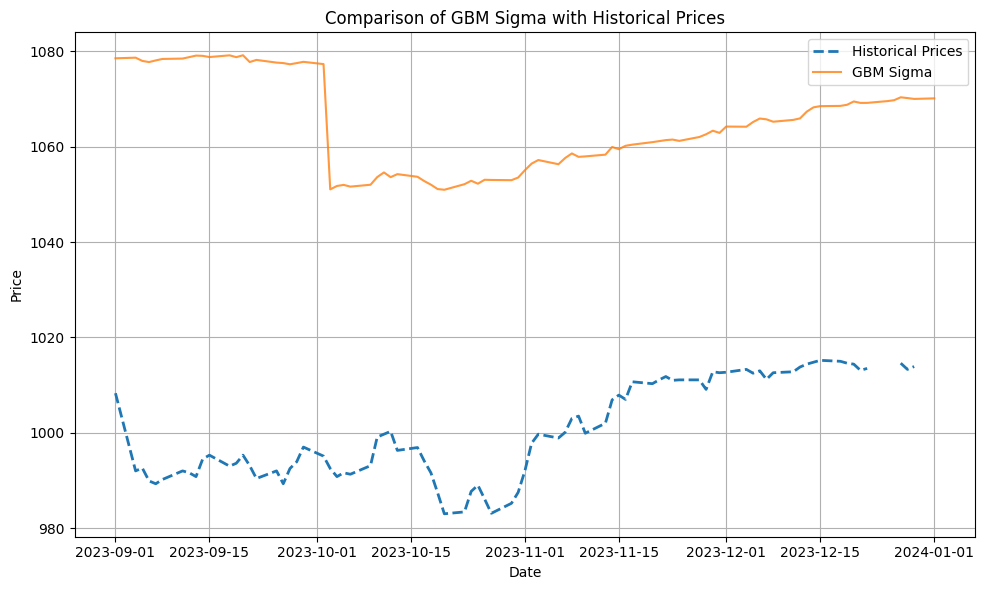

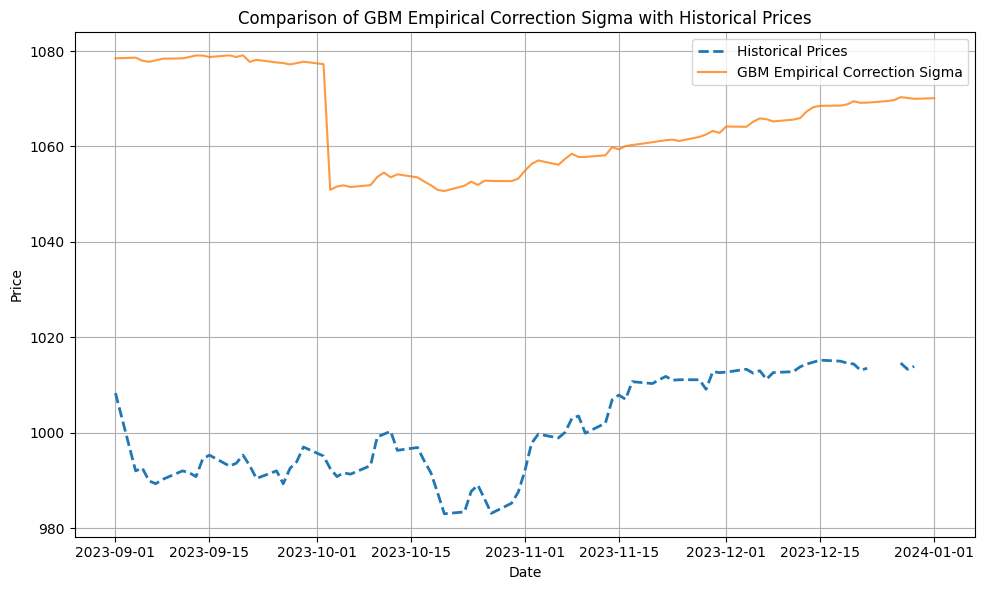

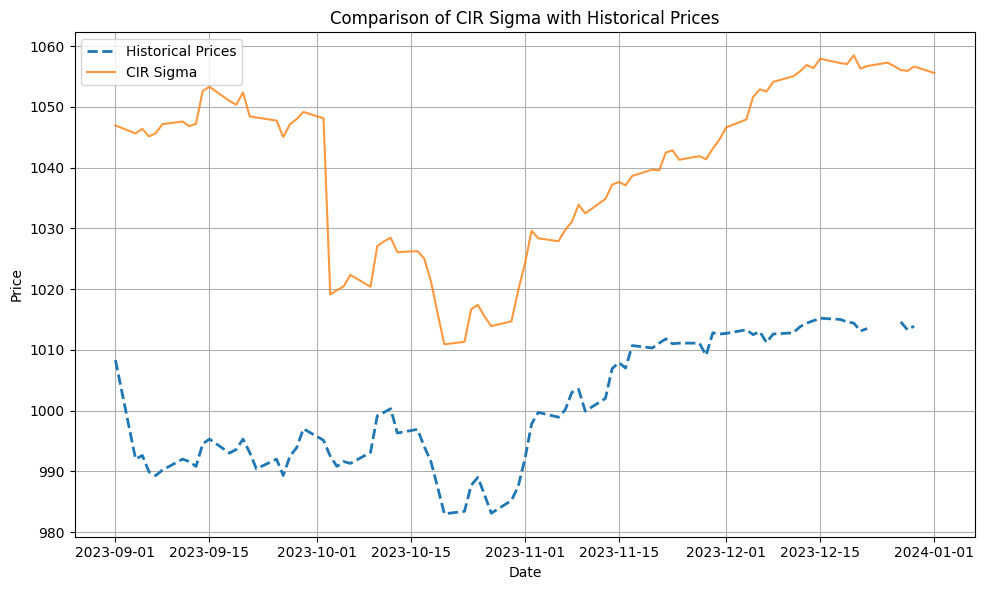

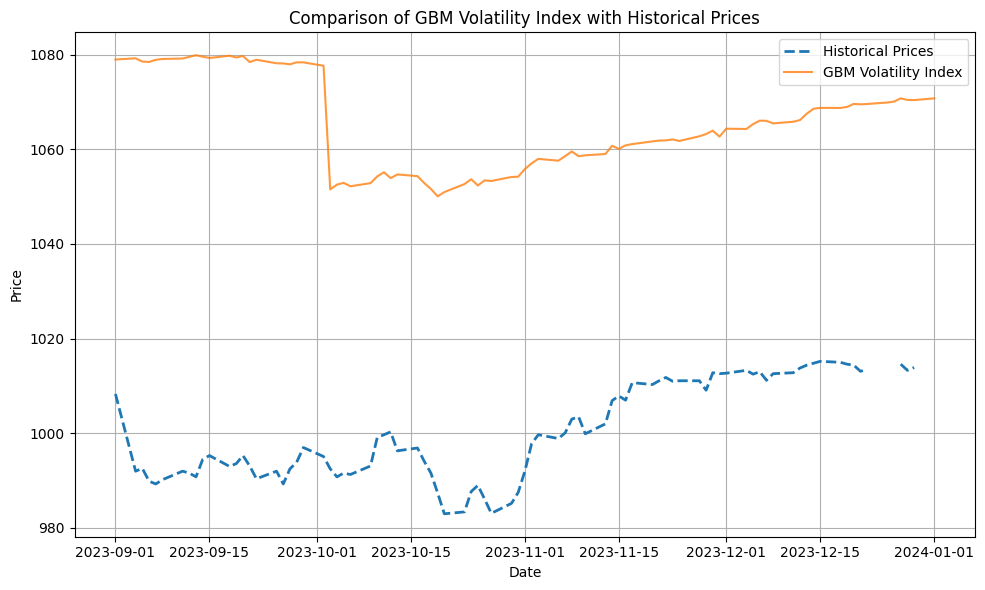

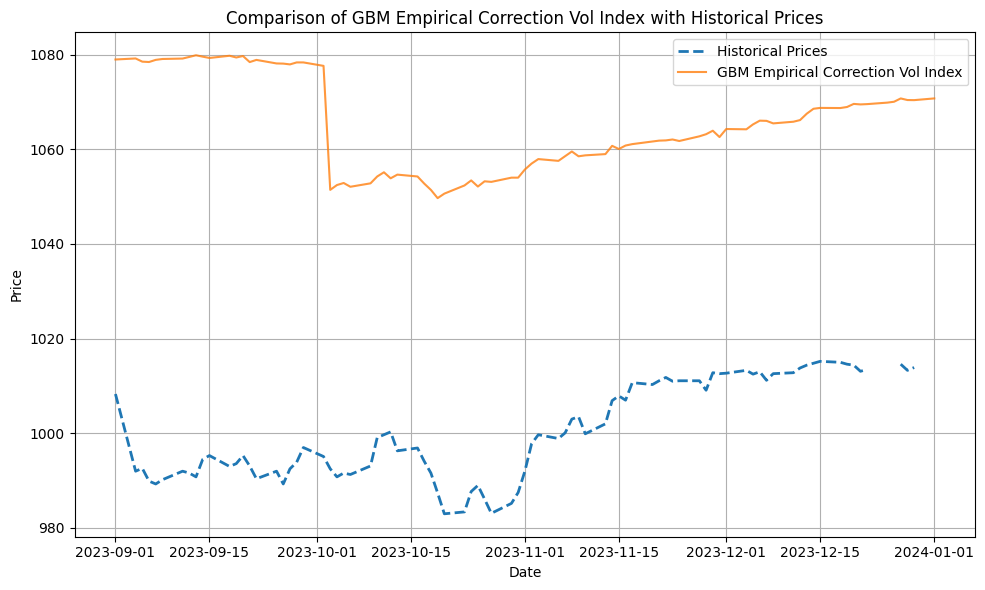

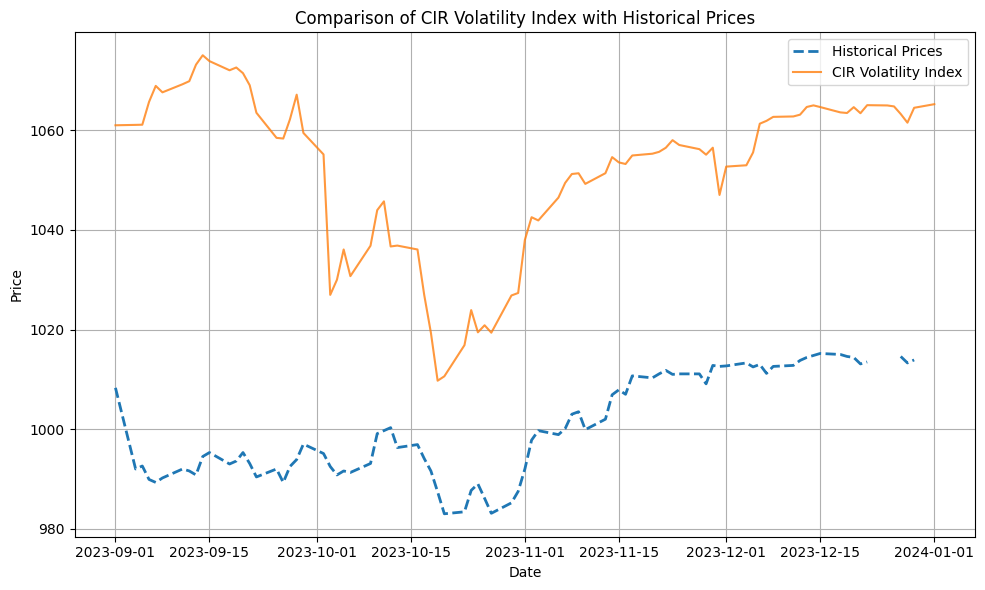

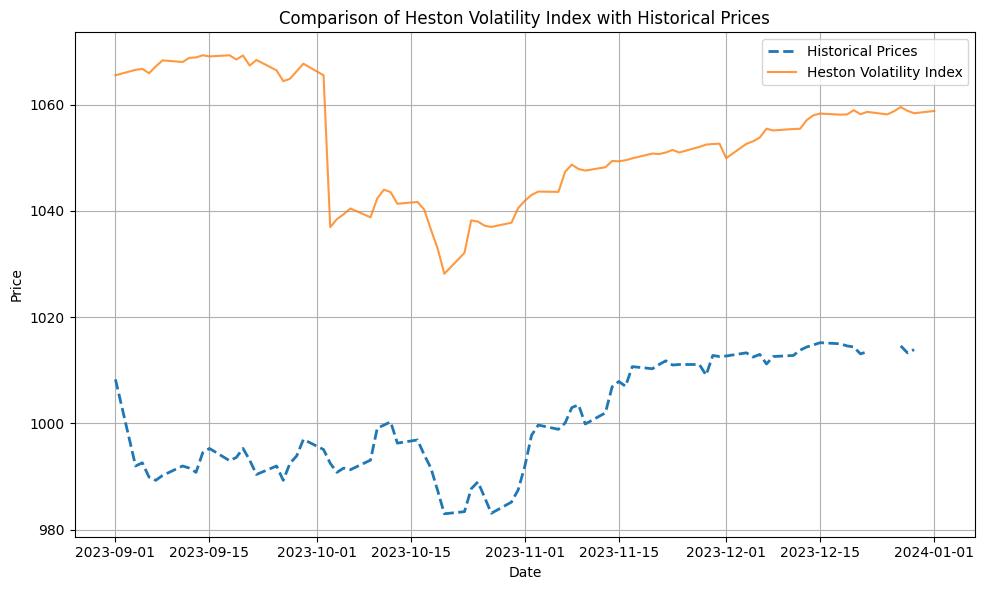

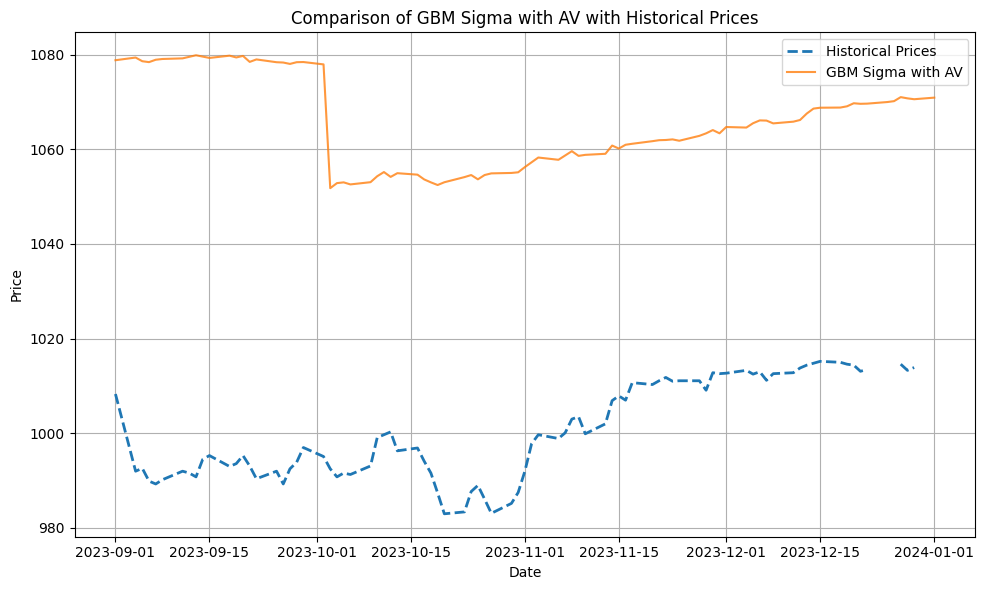

In [1348]:
import pandas as pd
import matplotlib.pyplot as plt

# List of models to compare
models = {
    "GBM_Mean_Price_Sigma": "GBM Sigma",
    "GBM_Mean_Price_EMcorrection_Sigma": "GBM Empirical Correction Sigma",
    "CIR_Mean_Price_Sigma": "CIR Sigma",
    "GBM_Mean_Price_VolIndex": "GBM Volatility Index",
    "GBM_Mean_Price_EMcorrection_VolIndex": "GBM Empirical Correction Vol Index",
    "CIR_Mean_Price_VolIndex": "CIR Volatility Index",
    "Heston_Mean_Price_VolIndex": "Heston Volatility Index",
    "av_data": "GBM Sigma with AV"
}

# Plot each model on a separate graph
for model, label in models.items():
    plt.figure(figsize=(10, 6))

    # Plot historical prices
    plt.plot(price_chart.index, price_chart["Historical_Price"], label="Historical Prices", linestyle='--', linewidth=2)

    # Plot the model
    plt.plot(price_chart.index, model_results[model], label=label, alpha=0.8)

    # Add labels, legend, and title
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Comparison of {label} with Historical Prices")
    plt.legend(loc="best")
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [1356]:
model_results = model_results.drop(columns="Start_Date")

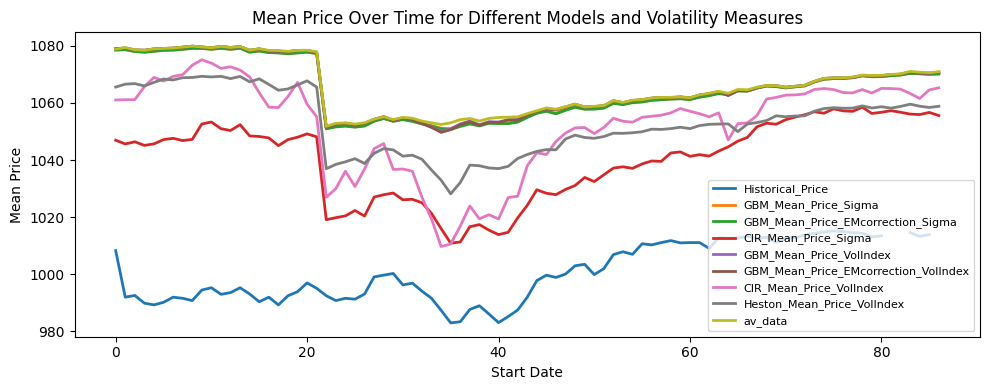

In [1357]:



def plot_price_chart(price_chart):
    plt.figure(figsize=(10, 4))

    # Iterate over each column and plot it
    for column in model_results.columns:
        plt.plot(model_results.index, model_results[column], label=column, linewidth=2)

    plt.xlabel('Start Date')
    plt.ylabel('Mean Price')
    plt.title('Mean Price Over Time for Different Models and Volatility Measures')
    plt.legend(loc='lower right', fontsize = 8)
    plt.tight_layout()
    plt.show()

# Call the function with the price_chart dataframe
plot_price_chart(model_results[['CIR_Mean_Price_Sigma', 'CIR_Mean_Price_VolIndex']])

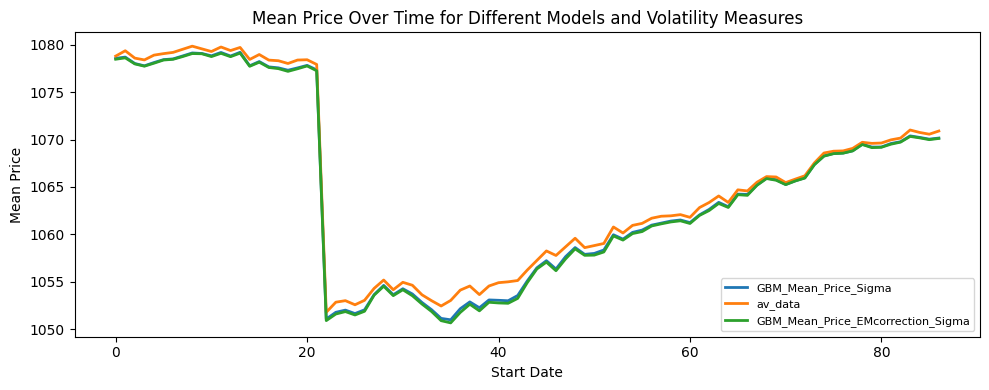

In [1365]:

models = {
    "GBM_Mean_Price_Sigma": "GBM Sigma",
    "av_data": "AV Index",
    "GBM_Mean_Price_EMcorrection_Sigma": "GBM Empirical Correction Sigma",
    # "Historical_Price": "Historical_Prices"

}

def plot_price_chart(price_chart):
    plt.figure(figsize=(10, 4))

    # Iterate over each column and plot it
    for model in models:
        plt.plot(model_results.index, model_results[model], label=model, linewidth=2)

    plt.xlabel('Start Date')
    plt.ylabel('Mean Price')
    plt.title('Mean Price Over Time for Different Models and Volatility Measures')
    plt.legend(loc='lower right', fontsize = 8)
    plt.tight_layout()
    plt.show()

# Call the function with the price_chart dataframe
plot_price_chart(price_chart)

In [1358]:
def calculate_bias_adjusted_error(model_prices, historical_prices):
    return np.mean((model_prices - historical_prices) / model_prices)

for column in model_results.columns:
    bias_error = calculate_bias_adjusted_error(model_results[column], model_results['Historical_Price'])
    print(f"{column}: Bias Adjusted Error = {bias_error:.4f}")

Historical_Price: Bias Adjusted Error = 0.0000
GBM_Mean_Price_Sigma: Bias Adjusted Error = 0.0600
GBM_Mean_Price_EMcorrection_Sigma: Bias Adjusted Error = 0.0599
CIR_Mean_Price_Sigma: Bias Adjusted Error = 0.0374
GBM_Mean_Price_VolIndex: Bias Adjusted Error = 0.0604
GBM_Mean_Price_EMcorrection_VolIndex: Bias Adjusted Error = 0.0604
CIR_Mean_Price_VolIndex: Bias Adjusted Error = 0.0485
Heston_Mean_Price_VolIndex: Bias Adjusted Error = 0.0495
av_data: Bias Adjusted Error = 0.0607


In [1359]:
from scipy.stats import spearmanr

for column in model_results.columns:
    corr, _ = spearmanr(model_results[column], model_results['Historical_Price'])
    print(f"{column}: Spearman Correlation = {corr:.2f}")

Historical_Price: Spearman Correlation = nan
GBM_Mean_Price_Sigma: Spearman Correlation = nan
GBM_Mean_Price_EMcorrection_Sigma: Spearman Correlation = nan
CIR_Mean_Price_Sigma: Spearman Correlation = nan
GBM_Mean_Price_VolIndex: Spearman Correlation = nan
GBM_Mean_Price_EMcorrection_VolIndex: Spearman Correlation = nan
CIR_Mean_Price_VolIndex: Spearman Correlation = nan
Heston_Mean_Price_VolIndex: Spearman Correlation = nan
av_data: Spearman Correlation = nan


In [1360]:
def calculate_mape(model_prices, historical_prices):
    return np.mean(np.abs((model_prices - historical_prices) / historical_prices)) * 100

for column in model_results.columns:
    mape = calculate_mape(model_results[column], model_results['Historical_Price'])
    print(f"{column}: MAPE = {mape:.2f}%")

Historical_Price: MAPE = 0.00%
GBM_Mean_Price_Sigma: MAPE = 6.40%
GBM_Mean_Price_EMcorrection_Sigma: MAPE = 6.39%
CIR_Mean_Price_Sigma: MAPE = 3.89%
GBM_Mean_Price_VolIndex: MAPE = 6.45%
GBM_Mean_Price_EMcorrection_VolIndex: MAPE = 6.44%
CIR_Mean_Price_VolIndex: MAPE = 5.12%
Heston_Mean_Price_VolIndex: MAPE = 5.23%
av_data: MAPE = 6.48%


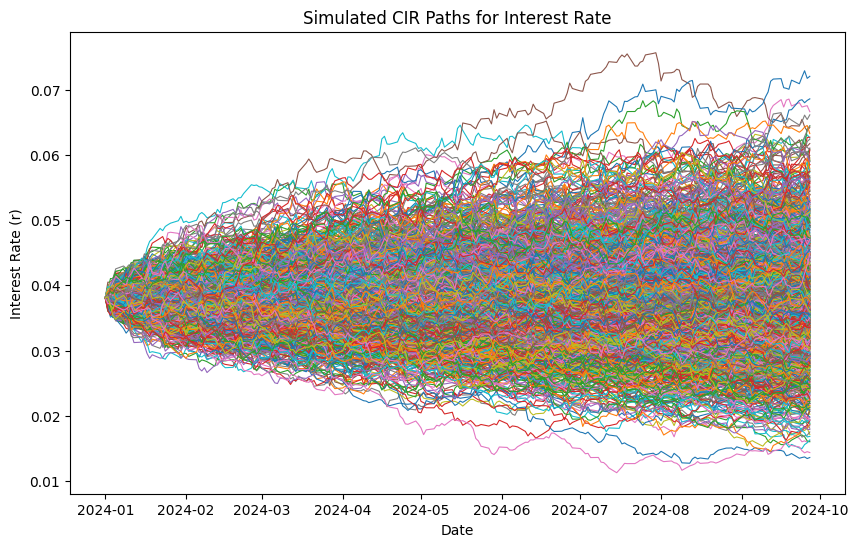

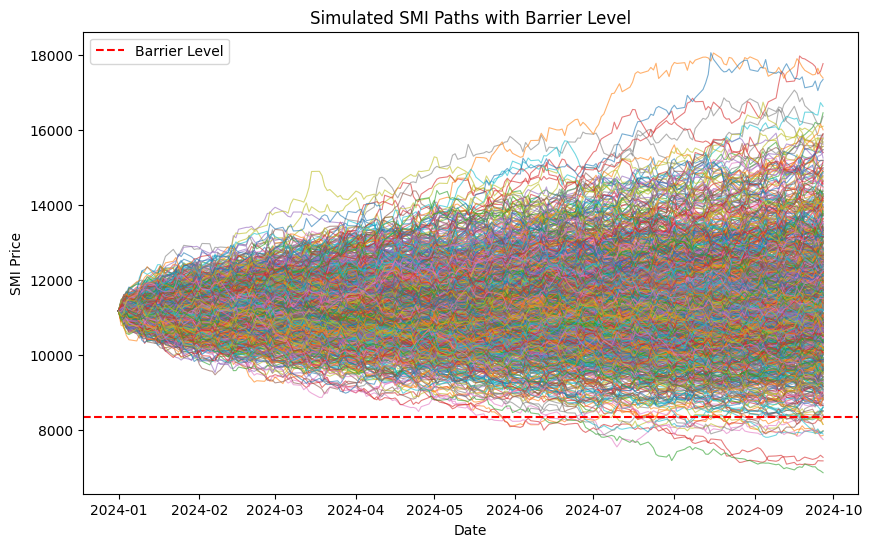

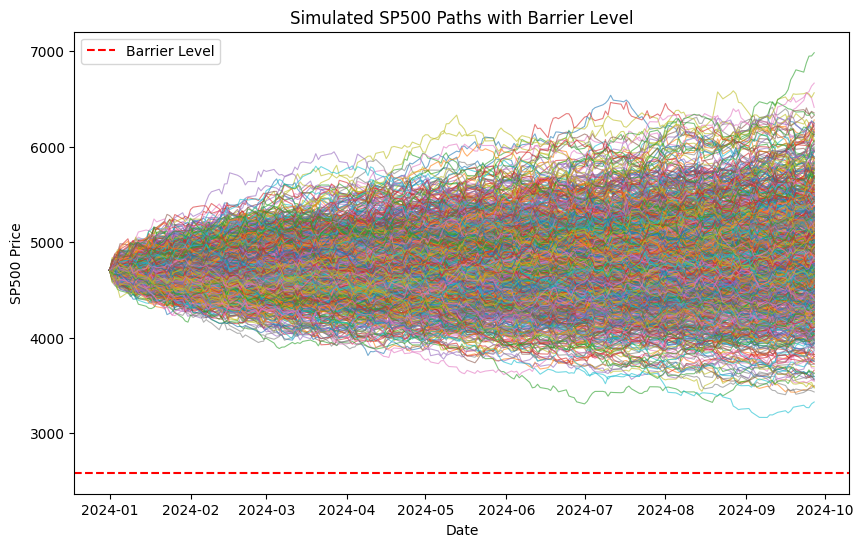

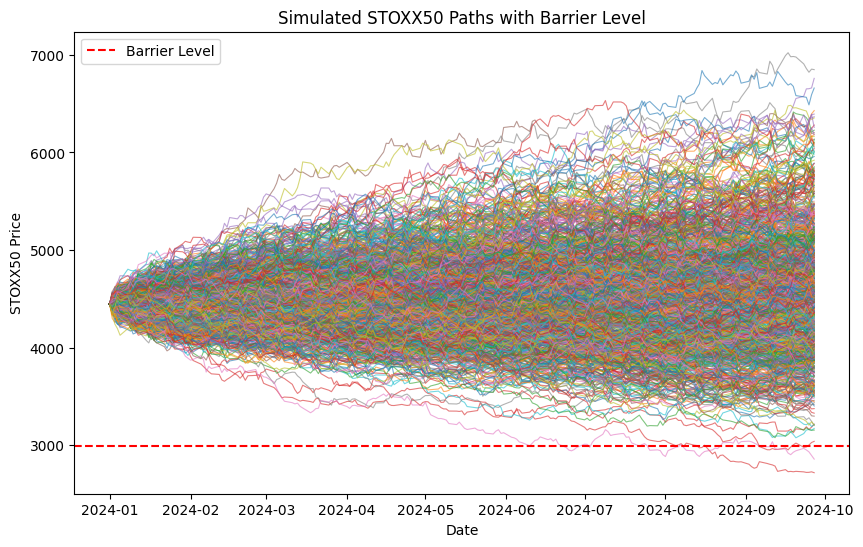

In [ ]:
## Checking if model is working correctly.

start_date = pd.to_datetime('2024-01-01')
dates = pd.bdate_range(start = start_date, end = final_date+pd.to_timedelta("1d"))
n_simulations = 1000
price_paths, r_paths = simulate_price_paths_with_CIR(start_date, n_simulations= n_simulations)
n_timesteps = len(dates)


sp500_init_level = 3977
stoxx_init_level = 4164
smi_init_level= 10786

eur_usd = eur["Price"][start_date]
chf_usd = chf["Price"][start_date]
stoxx_init_level = stoxx_init_level_local / eur_usd
smi_init_level = smi_init_level_local / chf_usd
sp500_barrier = sp500_init_level * 0.65
stoxx_barrier = stoxx_init_level * 0.65
smi_barrier = smi_init_level * 0.65
import matplotlib.pyplot as plt

# --- Plot Interest Rate Paths ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, r_paths.transpose()[i], lw=0.8)
plt.xlabel("Date")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

# --- Plot SMI Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['SMI'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=smi_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("SMI Price")
plt.title("Simulated SMI Paths with Barrier Level")
plt.legend()
plt.show()

# --- Plot SP500 Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['SP500'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=sp500_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Simulated SP500 Paths with Barrier Level")
plt.legend()
plt.show()

# --- Plot STOXX50 Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['STOXX50'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=stoxx_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("STOXX50 Price")
plt.title("Simulated STOXX50 Paths with Barrier Level")
plt.legend()
plt.show()

In [ ]:
x = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
np.mean(x)

np.float64(1062.9474562224718)

## Delta Calculation

In [ ]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2023-09-01')
dates = pd.bdate_range(start = start_date, end = '2024-01-01')
delta_chart = pd.DataFrame({"Start_Date":[], "sp500_delta":[], "smi_delta":[], "stoxx50_delta":[]})
h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
price_data = {
        'SMI': smi,
        'STOXX50': stoxx50,
        'SP500': sp500
    }

for start_date in dates:
    if start_date in delta_chart["Start_Date"]: continue
    nsim = 200
    sigma = {}
    for index in ['SMI', 'STOXX50', 'SP500']:
        #variance = returns[index].var(ddof= 1)*252
        t = vol_index.get(index)
        vol = t[t.index > start_date].iloc[-1].item()
        sigma[index] = vol/100
    h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
    deltas = {}
    initial_prices = {}
    for index in price_data:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in h:
        h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
        h_percent = 0.05
        h[i] = 1.0 + h_percent
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        upper_price = np.mean(cir)
        h[i] = 1.0 - h_percent
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        lower_price = np.mean(cir)
        epsilon = initial_prices.get(i)*h_percent
        deltas[i] = (upper_price-lower_price)/(2*epsilon)

    delta_chart.loc[len(delta_chart)+1] = {"Start_Date": start_date,
                                           "sp500_delta":deltas.get("SP500"),
                                           "smi_delta":deltas.get("SMI"),
                                           "stoxx50_delta":deltas.get("STOXX50")}
    print(start_date)


#Needs to have 5000> sims for vaguely accurate results
delta_chart.to_csv("delta_chart_overnight.csv")

2023-09-01 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00
2023-09-18 00:00:00
2023-09-19 00:00:00
2023-09-20 00:00:00
2023-09-21 00:00:00
2023-09-22 00:00:00
2023-09-25 00:00:00
2023-09-26 00:00:00
2023-09-27 00:00:00
2023-09-28 00:00:00
2023-09-29 00:00:00
2023-10-02 00:00:00
2023-10-03 00:00:00
2023-10-04 00:00:00
2023-10-05 00:00:00
2023-10-06 00:00:00
2023-10-09 00:00:00
2023-10-10 00:00:00
2023-10-11 00:00:00
2023-10-12 00:00:00
2023-10-13 00:00:00
2023-10-16 00:00:00
2023-10-17 00:00:00
2023-10-18 00:00:00
2023-10-19 00:00:00
2023-10-20 00:00:00
2023-10-23 00:00:00
2023-10-24 00:00:00
2023-10-25 00:00:00
2023-10-26 00:00:00
2023-10-27 00:00:00
2023-10-30 00:00:00
2023-10-31 00:00:00
2023-11-01 00:00:00
2023-11-02 00:00:00
2023-11-03 00:00:00
2023-11-06 00:00:00
2023-11-07 00:00:00
2023-11-08 00:00:00
2023-11-09 00:00:00


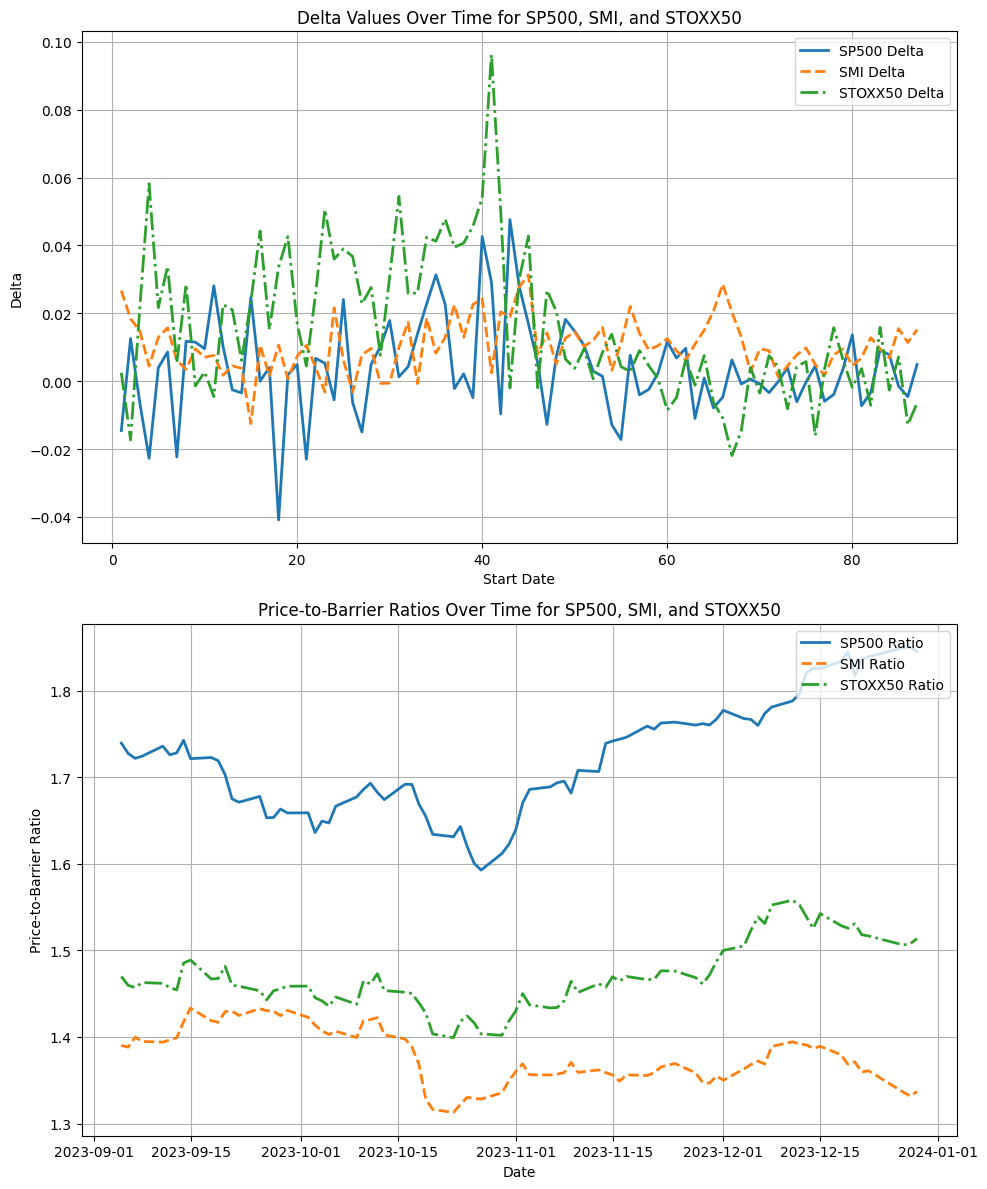

In [ ]:
#delta_chart.set_index("Start_Date", inplace = True)
#Might have to comment out if already set
sp500_init_level = 3977
stoxx_init_level = 4164
smi_init_level= 10786

delta_chart.rename(columns={"sp500_delta":"SP500", 	"smi_delta"	: "SMI", "stoxx50_delta":"STOXX50"}, inplace = True)

start_date = pd.to_datetime('2023-09-01')
end_date = pd.to_datetime('2024-01-01')

# Step 2: Filter the data for the specified timeframe
smi1 = smi[(smi.index > start_date) & (smi.index < end_date)]["Price"]
stoxx501 = stoxx50[(stoxx50.index > start_date) & (stoxx50.index < end_date)]["Price"]
sp5001 = sp500[(sp500.index > start_date) & (sp500.index < end_date)]["Price"]

# Step 3: Calculate the barriers
smi_barrier_df = smi_init_level * 0.65 / chf["Price"]
stoxx50_barrier_df = stoxx_init_level * 0.65 / eur["Price"]
sp500_barrier_df = sp500_barrier  # Assuming `sp500_barrier` contains the barrier price directly

# Step 4: Align filtered data with respective barriers
smi_filtered = smi1[smi1.index.isin(smi_barrier_df.index)]
smi_barrier_filtered = smi_barrier_df[smi_barrier_df.index.isin(smi_filtered.index)]

stoxx50_filtered = stoxx501[stoxx501.index.isin(stoxx50_barrier_df.index)]
stoxx50_barrier_filtered = stoxx50_barrier_df[stoxx50_barrier_df.index.isin(stoxx50_filtered.index)]


# Step 5: Calculate the ratios of price to barrier
smi_ratio = smi_filtered / smi_barrier_filtered
stoxx50_ratio = stoxx50_filtered / stoxx50_barrier_filtered
sp500_ratio = sp500["Price"] / sp500_barrier

# Combine the ratios into a DataFrame for easier comparison
ratios_df = pd.DataFrame({
    "SMI Price-to-Barrier Ratio": smi_ratio,
    "STOXX50 Price-to-Barrier Ratio": stoxx50_ratio,
    "SP500 Price-to-Barrier Ratio": sp500_ratio
}).dropna()

# Display the combined DataFrame
ratios_df
def plot_delta_chart_with_ratios(delta_chart):
    plt.figure(figsize=(10, 12))

    # First Plot: Delta Chart
    plt.subplot(2, 1, 1)
    plt.plot(delta_chart.index, delta_chart['SP500'], label='SP500 Delta', linestyle='-', linewidth=2)
    plt.plot(delta_chart.index, delta_chart['SMI'], label='SMI Delta', linestyle='--', linewidth=2)
    plt.plot(delta_chart.index, delta_chart['STOXX50'], label='STOXX50 Delta', linestyle='-.', linewidth=2)
    plt.xlabel('Start Date')
    plt.ylabel('Delta')
    plt.title('Delta Values Over Time for SP500, SMI, and STOXX50')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Second Plot: Ratios Chart
    plt.subplot(2, 1, 2)
    plt.plot(ratios_df.index, ratios_df['SP500 Price-to-Barrier Ratio'], label='SP500 Ratio', linestyle='-', linewidth=2)
    plt.plot(ratios_df.index, ratios_df['SMI Price-to-Barrier Ratio'], label='SMI Ratio', linestyle='--', linewidth=2)
    plt.plot(ratios_df.index, ratios_df['STOXX50 Price-to-Barrier Ratio'], label='STOXX50 Ratio', linestyle='-.', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Price-to-Barrier Ratio')
    plt.title('Price-to-Barrier Ratios Over Time for SP500, SMI, and STOXX50')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


    # Step 1: Define the timeframe



plot_delta_chart_with_ratios(delta_chart)

## Delta Hedging

In [ ]:
from sklearn.decomposition import PCA
delta_chart.rename(columns={"sp500_delta":"SP500", 	"smi_delta"	: "SMI", "stoxx50_delta":"STOXX50"}, inplace = True)
returns_diff = pd.DataFrame({"SP500": list(sp500["Price"] - sp500["Price"].shift(1)),
                            "SMI": list(smi["Price"] - smi["Price"].shift(1)),
                            "STOXX50": list(stoxx50["Price"] - stoxx50["Price"].shift(1))})
cov_matrix = returns.cov()

cov_array = cov_matrix.values
n_components = 1
pca = PCA(n_components=n_components)

pca.fit(cov_array)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_.T
print("Explained Variance:", pca.explained_variance_ratio_)
delta_factor = eigenvectors.T @ delta_chart[["SP500","SMI","STOXX50"]].values[0]
## so delta for each factor in pca
print("Delta Factor:",delta_factor)
hedge_positions_factor = -delta_factor
hedge_positions_asset = eigenvectors @ hedge_positions_factor
print("Orignal Hedge:", -delta_chart[["SP500","SMI","STOXX50"]].values[0])
print("Updated Hedge:", hedge_positions_asset)
print("Ignore the first one, i.e no need to hold S&P500 at current levels")
notional_amount = 1000

Explained Variance: [0.68023169]
Delta Factor: [0.00138231]
Orignal Hedge: [ 0.01457328 -0.02666583 -0.00246652]
Updated Hedge: [ 0.00037103  0.00025206 -0.00130751]
Ignore the first one, i.e no need to hold S&P500 at current levels


# The Heston-CIR Model

In [ ]:
# Helper function to plot results
def plot_simulation_results(price_paths, vol_paths, r_paths, output_dir="simulation_plots"):
    import os

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index in price_paths.keys():
        # Price paths plot
        plt.figure(figsize=(10, 6))
        plt.plot(price_paths[index][:, :5])  # Plot the first 5 simulations
        plt.title(f'Price Paths for {index}')
        plt.xlabel('Time Steps')
        plt.ylabel('Price')
        plt.grid()
        plt.savefig(os.path.join(output_dir, f'{index}_price_paths.png'))
        plt.close()

        # Volatility paths plot
        plt.figure(figsize=(10, 6))
        plt.plot(vol_paths[index][:, :5])  # Plot the first 5 simulations
        plt.title(f'Volatility Paths for {index}')
        plt.xlabel('Time Steps')
        plt.ylabel('Variance')
        plt.grid()
        plt.savefig(os.path.join(output_dir, f'{index}_volatility_paths.png'))
        plt.close()

    # Interest rate paths plot
    plt.figure(figsize=(10, 6))
    plt.plot(r_paths[:, :5])  # Plot the first 5 simulations
    plt.title('Interest Rate Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('Interest Rate')
    plt.grid()
    plt.savefig(os.path.join(output_dir, 'interest_rate_paths.png'))
    plt.close()

# Call the function to generate and save the plots
plot_simulation_results(price_paths, vol_paths, r_paths)